In [1]:
%%time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import os
from src.models.frontier import MultiStockEnv, Agent, backtest, maybe_make_dir
from src.config import market_tickers
from src.config.model_config import model_parameters

CPU times: user 5.81 s, sys: 4.25 s, total: 10.1 s
Wall time: 1.99 s


In [2]:
# papermill parameters
SEED_LIST = [
             0,
             #1111,
             #2222, 
             #3333, 
             #4444, 
             #5555,
             #6666,
             #7777,
             #8888,
             #9999
            ]

#TICKERS = market_tickers.DOW_30_TICKER
TICKERS = ['AAPL', 'AMD', 'CSCO', 'F', 'INTC']
MARKET_NAME = 'TEST_5'
MODEL_BASE_NAME = 'RL_CNN' # use either | 'RL_CNN' | 'RL_str_fcast' | 'RL_all_inp' |
FROM = '2019-01-01' # start of backtest
UNTIL = '2020-01-01' # end of backtest
NB_EPISODES = 200 # backtest model that was trained for this number of episodes

# investor preferences
GAMMA_TRADES = [0.1, 1, 10, 100]
GAMMA_RISKS = [0.1, 1, 10, 100, 1000]
GAMMA_HOLDS = [0.1, 1]

In [3]:
# Parameters
SEED_LIST = [0]
TICKERS = [
    "AAPL",
    "MSFT",
    "JPM",
    "V",
    "RTX",
    "PG",
    "GS",
    "NKE",
    "DIS",
    "AXP",
    "HD",
    "INTC",
    "WMT",
    "IBM",
    "MRK",
    "UNH",
    "KO",
    "CAT",
    "TRV",
    "JNJ",
    "CVX",
    "MCD",
    "VZ",
    "CSCO",
    "XOM",
    "BA",
    "MMM",
    "PFE",
    "WBA",
    "DD",
]
MARKET_NAME = "DOW_30"
MODEL_BASE_NAME = "RL_CNN"
FROM = "2018-01-01"
UNTIL = "2020-01-01"
NB_EPISODES = 200
GAMMA_TRADES = [7, 8, 9, 10, 11, 12]
GAMMA_RISKS = [1, 2, 3, 6, 10, 18, 32, 56, 100, 178, 316, 562, 1000, 5000, 10000]
GAMMA_HOLDS = [0.1, 1, 10, 100, 1000]


In [4]:
#------ small test-sweep ------#
# GAMMA_TRADES = [0.1, 1, 10, 100]
# GAMMA_RISKS = [0.1, 1, 10, 100, 1000]
# GAMMA_HOLDS = [0.1, 1]
#------ extended-boyd-sweep ------#
# GAMMA_TRADES =  [0.1, 0.5, 1, 2, 3, 4, 5, 5.5, 6, 6.5, 7, 7.5, 8, 9, 10, 11, 12, 15, 20, 30, 45, 60, 100, 200]
# GAMMA_RISKS = [0.1, 0.178, 0.316, 0.562, 1, 2, 3, 6, 10, 18, 32, 56, 100, 178, 316, 562, 1000, 2000, 5000, 10000, 20000]
#---------------------------------#

GAMMA_TRIOS = []
for tr in GAMMA_TRADES:
    for ri in GAMMA_RISKS:
        for hd in GAMMA_HOLDS:
            GAMMA_TRIOS.append((tr, ri, hd))
        
#format: (gamma_trade, gamma_risk, gamma_hold)
print('number of trios: ', len(GAMMA_TRIOS))
#GAMMA_TRIOS

number of trios:  450


In [5]:
# other constants and parameters
TICKERS.sort()
FILE_PERIOD = '1d' # weekly='5d', daily='1d'
HALF_SPREAD = 0.0005/2.0 # 'a' in transaction cost function
NONLIN_COEFF = 1.0 # 'b' transaction cost function
POWER = 1.5 # power for change in poertfolio vector used in transaction cost
INIT_PORTFOLIO = 100000000.0 # initial portfolio value

USE_FORECASTS = model_parameters[MODEL_BASE_NAME]['use_forecasts'] # whether to use forecasts as inputs to agent policy net or not
NB_FORECASTS = model_parameters[MODEL_BASE_NAME]['nb_forecasts'] # number of forecasts to use in state. Set to None for no forecasts
FORECAST_TYPE = model_parameters[MODEL_BASE_NAME]['forecast_type'] # use 'strong' or 'weak' forecasts (if no forecasts given, this does not matter)
USE_CNN_STATE = model_parameters[MODEL_BASE_NAME]['use_cnn_state'] # whether to pass log-rets block for CNN part of policy net (set to false for forecast only)

TEST_NAME = f'{MARKET_NAME}_{MODEL_BASE_NAME}_seeds_{SEED_LIST[0]}_etc'
RESULTS_DIR = f'../experiments/{MARKET_NAME}/seeded/{MODEL_BASE_NAME}/backtests/'
DATA_DIR = f'../data/{MARKET_NAME}/preprocessed_data/'

## create agent(s) and backtest in new backtest env

In [6]:
%%time
# make directory for results if it does not exist already
maybe_make_dir(RESULTS_DIR)

print('creating environment and agent...')
env = MultiStockEnv(tickers=TICKERS, 
                    from_date=FROM,
                    until=UNTIL, 
                    #nb_episodes=100,
                    cash_key='USDOLLAR', 
                    #gamma_risk=GAMMA_RISK, 
                    #gamma_trade=GAMMA_TRADE,
                    #half_spread=HALF_SPREAD, 
                    nonlin_coef=NONLIN_COEFF, 
                    power=POWER, 
                    datadir=DATA_DIR, 
                    state_lookback_window=20, 
                    #distribution=EPISODE_DRAW_DISTRIBUTION,
                    #days_duration=DAYS_IN_EPISODE, 
                    mode='backtest', 
                    random_seed=7,
                    init_portfolio=INIT_PORTFOLIO, 
                    period_in_file_name=FILE_PERIOD, 
                    nb_forecasts=NB_FORECASTS, 
                    forecast_type=FORECAST_TYPE,
                    use_CNN_state=USE_CNN_STATE,
                    verbose=False)

agent = Agent(alpha=0.001, 
              gamma=0.99, 
              n_assets=len(TICKERS)+1, 
              tau=5, 
              lookback_window=20, 
              n_feature_maps=len(TICKERS)+1,
              use_forecasts=USE_FORECASTS,
              use_CNN_state=USE_CNN_STATE,
              allow_long_short_trades=True)

results_dict = {}
#actions_dict = {}
print('backtesting:')

total_backtests = len(SEED_LIST) * len(GAMMA_TRIOS)
backtest_counter = 0

for RANDOM_SEED in SEED_LIST:
    for (GAMMA_TRADE, GAMMA_RISK, GAMMA_HOLD) in GAMMA_TRIOS:
        
        backtest_counter += 1
        print(f'\t[{backtest_counter}/{total_backtests}]\t{MODEL_BASE_NAME}: gamma_trade={GAMMA_TRADE}, gamma_risk={GAMMA_RISK}, gamma_hold={GAMMA_HOLD}, seed={RANDOM_SEED}...')
        
        # load trained RL model for backtesting
        SAVED_MODEL_DIR = f'../experiments/{MARKET_NAME}/seeded/{MODEL_BASE_NAME}/seed_{RANDOM_SEED}/trade_{GAMMA_TRADE}_risk_{GAMMA_RISK}_hold_{GAMMA_HOLD}/models/{MODEL_BASE_NAME}_seed_{RANDOM_SEED}_{NB_EPISODES}'
        # set dir where actions csv file will be saved
        actions_dir = f'../experiments/{MARKET_NAME}/seeded/{MODEL_BASE_NAME}/seed_{RANDOM_SEED}/trade_{GAMMA_TRADE}_risk_{GAMMA_RISK}_hold_{GAMMA_HOLD}'
        
        try:
            rl_rets, rl_actions = backtest(agent, env, weights_file_dir=SAVED_MODEL_DIR, verbose=False)
            
            #rl_rets = pd.Series(data=rl_rets, index=env.returns.loc[FROM:UNTIL].iloc[1:].index)
            #rl_actions = pd.DataFrame(data=rl_actions, index=env.returns.loc[FROM:UNTIL].iloc[0:].index, columns=TICKERS+['USDOLLAR'])
            rl_rets = pd.Series(data=rl_rets, index=env.returns.loc[FROM:UNTIL].iloc[:-1].index)
            rl_rets = rl_rets.shift(1)
            rl_rets.iloc[0] = 0
            rl_actions = pd.DataFrame(data=rl_actions[:-1], index=env.returns.loc[FROM:UNTIL].iloc[:-1].index, columns=TICKERS+['USDOLLAR'])
            
            # save actions
            rl_actions.to_csv(f'{actions_dir}/actions.csv')
            #print('actions saved.')

            cash_rets = env.returns.loc[FROM:UNTIL, env.cash_key].iloc[:-1]
            excess_rets = rl_rets - cash_rets

            R_e = excess_rets.mean() * 100 * 252
            sigma_e = excess_rets.std() * 100 * np.sqrt(252)
            sharpe = R_e / sigma_e

            results_dict[(GAMMA_TRADE, GAMMA_RISK, GAMMA_HOLD, RANDOM_SEED)] = {'excess_return':R_e, 'excess_risk':sigma_e, 'sharpe':sharpe}
        except Exception as e:
            print(f'**error for model: trade_{GAMMA_TRADE}_risk_{GAMMA_RISK}_hold_{GAMMA_HOLD}')
            #print(e)

creating environment and agent...


backtesting:
	[1/450]	RL_CNN: gamma_trade=7, gamma_risk=1, gamma_hold=0.1, seed=0...


	[2/450]	RL_CNN: gamma_trade=7, gamma_risk=1, gamma_hold=1, seed=0...


	[3/450]	RL_CNN: gamma_trade=7, gamma_risk=1, gamma_hold=10, seed=0...


	[4/450]	RL_CNN: gamma_trade=7, gamma_risk=1, gamma_hold=100, seed=0...


	[5/450]	RL_CNN: gamma_trade=7, gamma_risk=1, gamma_hold=1000, seed=0...


	[6/450]	RL_CNN: gamma_trade=7, gamma_risk=2, gamma_hold=0.1, seed=0...


	[7/450]	RL_CNN: gamma_trade=7, gamma_risk=2, gamma_hold=1, seed=0...


	[8/450]	RL_CNN: gamma_trade=7, gamma_risk=2, gamma_hold=10, seed=0...


	[9/450]	RL_CNN: gamma_trade=7, gamma_risk=2, gamma_hold=100, seed=0...


	[10/450]	RL_CNN: gamma_trade=7, gamma_risk=2, gamma_hold=1000, seed=0...


	[11/450]	RL_CNN: gamma_trade=7, gamma_risk=3, gamma_hold=0.1, seed=0...


	[12/450]	RL_CNN: gamma_trade=7, gamma_risk=3, gamma_hold=1, seed=0...


	[13/450]	RL_CNN: gamma_trade=7, gamma_risk=3, gamma_hold=10, seed=0...


	[14/450]	RL_CNN: gamma_trade=7, gamma_risk=3, gamma_hold=100, seed=0...


	[15/450]	RL_CNN: gamma_trade=7, gamma_risk=3, gamma_hold=1000, seed=0...


	[16/450]	RL_CNN: gamma_trade=7, gamma_risk=6, gamma_hold=0.1, seed=0...


	[17/450]	RL_CNN: gamma_trade=7, gamma_risk=6, gamma_hold=1, seed=0...


	[18/450]	RL_CNN: gamma_trade=7, gamma_risk=6, gamma_hold=10, seed=0...


	[19/450]	RL_CNN: gamma_trade=7, gamma_risk=6, gamma_hold=100, seed=0...


	[20/450]	RL_CNN: gamma_trade=7, gamma_risk=6, gamma_hold=1000, seed=0...


	[21/450]	RL_CNN: gamma_trade=7, gamma_risk=10, gamma_hold=0.1, seed=0...


	[22/450]	RL_CNN: gamma_trade=7, gamma_risk=10, gamma_hold=1, seed=0...


	[23/450]	RL_CNN: gamma_trade=7, gamma_risk=10, gamma_hold=10, seed=0...


	[24/450]	RL_CNN: gamma_trade=7, gamma_risk=10, gamma_hold=100, seed=0...


	[25/450]	RL_CNN: gamma_trade=7, gamma_risk=10, gamma_hold=1000, seed=0...


	[26/450]	RL_CNN: gamma_trade=7, gamma_risk=18, gamma_hold=0.1, seed=0...


	[27/450]	RL_CNN: gamma_trade=7, gamma_risk=18, gamma_hold=1, seed=0...


	[28/450]	RL_CNN: gamma_trade=7, gamma_risk=18, gamma_hold=10, seed=0...


	[29/450]	RL_CNN: gamma_trade=7, gamma_risk=18, gamma_hold=100, seed=0...


	[30/450]	RL_CNN: gamma_trade=7, gamma_risk=18, gamma_hold=1000, seed=0...


	[31/450]	RL_CNN: gamma_trade=7, gamma_risk=32, gamma_hold=0.1, seed=0...


	[32/450]	RL_CNN: gamma_trade=7, gamma_risk=32, gamma_hold=1, seed=0...


	[33/450]	RL_CNN: gamma_trade=7, gamma_risk=32, gamma_hold=10, seed=0...


	[34/450]	RL_CNN: gamma_trade=7, gamma_risk=32, gamma_hold=100, seed=0...


	[35/450]	RL_CNN: gamma_trade=7, gamma_risk=32, gamma_hold=1000, seed=0...


	[36/450]	RL_CNN: gamma_trade=7, gamma_risk=56, gamma_hold=0.1, seed=0...


	[37/450]	RL_CNN: gamma_trade=7, gamma_risk=56, gamma_hold=1, seed=0...


	[38/450]	RL_CNN: gamma_trade=7, gamma_risk=56, gamma_hold=10, seed=0...


	[39/450]	RL_CNN: gamma_trade=7, gamma_risk=56, gamma_hold=100, seed=0...


	[40/450]	RL_CNN: gamma_trade=7, gamma_risk=56, gamma_hold=1000, seed=0...


	[41/450]	RL_CNN: gamma_trade=7, gamma_risk=100, gamma_hold=0.1, seed=0...


	[42/450]	RL_CNN: gamma_trade=7, gamma_risk=100, gamma_hold=1, seed=0...


	[43/450]	RL_CNN: gamma_trade=7, gamma_risk=100, gamma_hold=10, seed=0...


	[44/450]	RL_CNN: gamma_trade=7, gamma_risk=100, gamma_hold=100, seed=0...


	[45/450]	RL_CNN: gamma_trade=7, gamma_risk=100, gamma_hold=1000, seed=0...


	[46/450]	RL_CNN: gamma_trade=7, gamma_risk=178, gamma_hold=0.1, seed=0...


	[47/450]	RL_CNN: gamma_trade=7, gamma_risk=178, gamma_hold=1, seed=0...


	[48/450]	RL_CNN: gamma_trade=7, gamma_risk=178, gamma_hold=10, seed=0...


	[49/450]	RL_CNN: gamma_trade=7, gamma_risk=178, gamma_hold=100, seed=0...


	[50/450]	RL_CNN: gamma_trade=7, gamma_risk=178, gamma_hold=1000, seed=0...


	[51/450]	RL_CNN: gamma_trade=7, gamma_risk=316, gamma_hold=0.1, seed=0...


	[52/450]	RL_CNN: gamma_trade=7, gamma_risk=316, gamma_hold=1, seed=0...


	[53/450]	RL_CNN: gamma_trade=7, gamma_risk=316, gamma_hold=10, seed=0...


	[54/450]	RL_CNN: gamma_trade=7, gamma_risk=316, gamma_hold=100, seed=0...


	[55/450]	RL_CNN: gamma_trade=7, gamma_risk=316, gamma_hold=1000, seed=0...


	[56/450]	RL_CNN: gamma_trade=7, gamma_risk=562, gamma_hold=0.1, seed=0...


	[57/450]	RL_CNN: gamma_trade=7, gamma_risk=562, gamma_hold=1, seed=0...


	[58/450]	RL_CNN: gamma_trade=7, gamma_risk=562, gamma_hold=10, seed=0...


	[59/450]	RL_CNN: gamma_trade=7, gamma_risk=562, gamma_hold=100, seed=0...


	[60/450]	RL_CNN: gamma_trade=7, gamma_risk=562, gamma_hold=1000, seed=0...


	[61/450]	RL_CNN: gamma_trade=7, gamma_risk=1000, gamma_hold=0.1, seed=0...


	[62/450]	RL_CNN: gamma_trade=7, gamma_risk=1000, gamma_hold=1, seed=0...


	[63/450]	RL_CNN: gamma_trade=7, gamma_risk=1000, gamma_hold=10, seed=0...


	[64/450]	RL_CNN: gamma_trade=7, gamma_risk=1000, gamma_hold=100, seed=0...


	[65/450]	RL_CNN: gamma_trade=7, gamma_risk=1000, gamma_hold=1000, seed=0...


	[66/450]	RL_CNN: gamma_trade=7, gamma_risk=5000, gamma_hold=0.1, seed=0...


	[67/450]	RL_CNN: gamma_trade=7, gamma_risk=5000, gamma_hold=1, seed=0...


	[68/450]	RL_CNN: gamma_trade=7, gamma_risk=5000, gamma_hold=10, seed=0...


	[69/450]	RL_CNN: gamma_trade=7, gamma_risk=5000, gamma_hold=100, seed=0...


	[70/450]	RL_CNN: gamma_trade=7, gamma_risk=5000, gamma_hold=1000, seed=0...


	[71/450]	RL_CNN: gamma_trade=7, gamma_risk=10000, gamma_hold=0.1, seed=0...


	[72/450]	RL_CNN: gamma_trade=7, gamma_risk=10000, gamma_hold=1, seed=0...


	[73/450]	RL_CNN: gamma_trade=7, gamma_risk=10000, gamma_hold=10, seed=0...


	[74/450]	RL_CNN: gamma_trade=7, gamma_risk=10000, gamma_hold=100, seed=0...


	[75/450]	RL_CNN: gamma_trade=7, gamma_risk=10000, gamma_hold=1000, seed=0...


	[76/450]	RL_CNN: gamma_trade=8, gamma_risk=1, gamma_hold=0.1, seed=0...


	[77/450]	RL_CNN: gamma_trade=8, gamma_risk=1, gamma_hold=1, seed=0...


	[78/450]	RL_CNN: gamma_trade=8, gamma_risk=1, gamma_hold=10, seed=0...


	[79/450]	RL_CNN: gamma_trade=8, gamma_risk=1, gamma_hold=100, seed=0...


	[80/450]	RL_CNN: gamma_trade=8, gamma_risk=1, gamma_hold=1000, seed=0...


	[81/450]	RL_CNN: gamma_trade=8, gamma_risk=2, gamma_hold=0.1, seed=0...


	[82/450]	RL_CNN: gamma_trade=8, gamma_risk=2, gamma_hold=1, seed=0...


	[83/450]	RL_CNN: gamma_trade=8, gamma_risk=2, gamma_hold=10, seed=0...


	[84/450]	RL_CNN: gamma_trade=8, gamma_risk=2, gamma_hold=100, seed=0...


	[85/450]	RL_CNN: gamma_trade=8, gamma_risk=2, gamma_hold=1000, seed=0...


	[86/450]	RL_CNN: gamma_trade=8, gamma_risk=3, gamma_hold=0.1, seed=0...


	[87/450]	RL_CNN: gamma_trade=8, gamma_risk=3, gamma_hold=1, seed=0...


	[88/450]	RL_CNN: gamma_trade=8, gamma_risk=3, gamma_hold=10, seed=0...


	[89/450]	RL_CNN: gamma_trade=8, gamma_risk=3, gamma_hold=100, seed=0...


	[90/450]	RL_CNN: gamma_trade=8, gamma_risk=3, gamma_hold=1000, seed=0...


	[91/450]	RL_CNN: gamma_trade=8, gamma_risk=6, gamma_hold=0.1, seed=0...


	[92/450]	RL_CNN: gamma_trade=8, gamma_risk=6, gamma_hold=1, seed=0...


	[93/450]	RL_CNN: gamma_trade=8, gamma_risk=6, gamma_hold=10, seed=0...


	[94/450]	RL_CNN: gamma_trade=8, gamma_risk=6, gamma_hold=100, seed=0...


	[95/450]	RL_CNN: gamma_trade=8, gamma_risk=6, gamma_hold=1000, seed=0...


	[96/450]	RL_CNN: gamma_trade=8, gamma_risk=10, gamma_hold=0.1, seed=0...


	[97/450]	RL_CNN: gamma_trade=8, gamma_risk=10, gamma_hold=1, seed=0...


	[98/450]	RL_CNN: gamma_trade=8, gamma_risk=10, gamma_hold=10, seed=0...


	[99/450]	RL_CNN: gamma_trade=8, gamma_risk=10, gamma_hold=100, seed=0...


	[100/450]	RL_CNN: gamma_trade=8, gamma_risk=10, gamma_hold=1000, seed=0...


	[101/450]	RL_CNN: gamma_trade=8, gamma_risk=18, gamma_hold=0.1, seed=0...


	[102/450]	RL_CNN: gamma_trade=8, gamma_risk=18, gamma_hold=1, seed=0...


	[103/450]	RL_CNN: gamma_trade=8, gamma_risk=18, gamma_hold=10, seed=0...


	[104/450]	RL_CNN: gamma_trade=8, gamma_risk=18, gamma_hold=100, seed=0...


	[105/450]	RL_CNN: gamma_trade=8, gamma_risk=18, gamma_hold=1000, seed=0...


	[106/450]	RL_CNN: gamma_trade=8, gamma_risk=32, gamma_hold=0.1, seed=0...


	[107/450]	RL_CNN: gamma_trade=8, gamma_risk=32, gamma_hold=1, seed=0...


	[108/450]	RL_CNN: gamma_trade=8, gamma_risk=32, gamma_hold=10, seed=0...


	[109/450]	RL_CNN: gamma_trade=8, gamma_risk=32, gamma_hold=100, seed=0...


	[110/450]	RL_CNN: gamma_trade=8, gamma_risk=32, gamma_hold=1000, seed=0...


	[111/450]	RL_CNN: gamma_trade=8, gamma_risk=56, gamma_hold=0.1, seed=0...


	[112/450]	RL_CNN: gamma_trade=8, gamma_risk=56, gamma_hold=1, seed=0...


	[113/450]	RL_CNN: gamma_trade=8, gamma_risk=56, gamma_hold=10, seed=0...


	[114/450]	RL_CNN: gamma_trade=8, gamma_risk=56, gamma_hold=100, seed=0...


	[115/450]	RL_CNN: gamma_trade=8, gamma_risk=56, gamma_hold=1000, seed=0...


	[116/450]	RL_CNN: gamma_trade=8, gamma_risk=100, gamma_hold=0.1, seed=0...


	[117/450]	RL_CNN: gamma_trade=8, gamma_risk=100, gamma_hold=1, seed=0...


	[118/450]	RL_CNN: gamma_trade=8, gamma_risk=100, gamma_hold=10, seed=0...


	[119/450]	RL_CNN: gamma_trade=8, gamma_risk=100, gamma_hold=100, seed=0...


	[120/450]	RL_CNN: gamma_trade=8, gamma_risk=100, gamma_hold=1000, seed=0...


	[121/450]	RL_CNN: gamma_trade=8, gamma_risk=178, gamma_hold=0.1, seed=0...


	[122/450]	RL_CNN: gamma_trade=8, gamma_risk=178, gamma_hold=1, seed=0...


	[123/450]	RL_CNN: gamma_trade=8, gamma_risk=178, gamma_hold=10, seed=0...


	[124/450]	RL_CNN: gamma_trade=8, gamma_risk=178, gamma_hold=100, seed=0...


	[125/450]	RL_CNN: gamma_trade=8, gamma_risk=178, gamma_hold=1000, seed=0...


	[126/450]	RL_CNN: gamma_trade=8, gamma_risk=316, gamma_hold=0.1, seed=0...


	[127/450]	RL_CNN: gamma_trade=8, gamma_risk=316, gamma_hold=1, seed=0...


	[128/450]	RL_CNN: gamma_trade=8, gamma_risk=316, gamma_hold=10, seed=0...


	[129/450]	RL_CNN: gamma_trade=8, gamma_risk=316, gamma_hold=100, seed=0...


	[130/450]	RL_CNN: gamma_trade=8, gamma_risk=316, gamma_hold=1000, seed=0...


	[131/450]	RL_CNN: gamma_trade=8, gamma_risk=562, gamma_hold=0.1, seed=0...


	[132/450]	RL_CNN: gamma_trade=8, gamma_risk=562, gamma_hold=1, seed=0...


	[133/450]	RL_CNN: gamma_trade=8, gamma_risk=562, gamma_hold=10, seed=0...


	[134/450]	RL_CNN: gamma_trade=8, gamma_risk=562, gamma_hold=100, seed=0...


	[135/450]	RL_CNN: gamma_trade=8, gamma_risk=562, gamma_hold=1000, seed=0...


	[136/450]	RL_CNN: gamma_trade=8, gamma_risk=1000, gamma_hold=0.1, seed=0...


	[137/450]	RL_CNN: gamma_trade=8, gamma_risk=1000, gamma_hold=1, seed=0...


	[138/450]	RL_CNN: gamma_trade=8, gamma_risk=1000, gamma_hold=10, seed=0...


	[139/450]	RL_CNN: gamma_trade=8, gamma_risk=1000, gamma_hold=100, seed=0...


	[140/450]	RL_CNN: gamma_trade=8, gamma_risk=1000, gamma_hold=1000, seed=0...


	[141/450]	RL_CNN: gamma_trade=8, gamma_risk=5000, gamma_hold=0.1, seed=0...


	[142/450]	RL_CNN: gamma_trade=8, gamma_risk=5000, gamma_hold=1, seed=0...


	[143/450]	RL_CNN: gamma_trade=8, gamma_risk=5000, gamma_hold=10, seed=0...


	[144/450]	RL_CNN: gamma_trade=8, gamma_risk=5000, gamma_hold=100, seed=0...


	[145/450]	RL_CNN: gamma_trade=8, gamma_risk=5000, gamma_hold=1000, seed=0...


	[146/450]	RL_CNN: gamma_trade=8, gamma_risk=10000, gamma_hold=0.1, seed=0...


	[147/450]	RL_CNN: gamma_trade=8, gamma_risk=10000, gamma_hold=1, seed=0...


	[148/450]	RL_CNN: gamma_trade=8, gamma_risk=10000, gamma_hold=10, seed=0...


	[149/450]	RL_CNN: gamma_trade=8, gamma_risk=10000, gamma_hold=100, seed=0...


	[150/450]	RL_CNN: gamma_trade=8, gamma_risk=10000, gamma_hold=1000, seed=0...


	[151/450]	RL_CNN: gamma_trade=9, gamma_risk=1, gamma_hold=0.1, seed=0...


	[152/450]	RL_CNN: gamma_trade=9, gamma_risk=1, gamma_hold=1, seed=0...


	[153/450]	RL_CNN: gamma_trade=9, gamma_risk=1, gamma_hold=10, seed=0...


	[154/450]	RL_CNN: gamma_trade=9, gamma_risk=1, gamma_hold=100, seed=0...


	[155/450]	RL_CNN: gamma_trade=9, gamma_risk=1, gamma_hold=1000, seed=0...


	[156/450]	RL_CNN: gamma_trade=9, gamma_risk=2, gamma_hold=0.1, seed=0...


	[157/450]	RL_CNN: gamma_trade=9, gamma_risk=2, gamma_hold=1, seed=0...


	[158/450]	RL_CNN: gamma_trade=9, gamma_risk=2, gamma_hold=10, seed=0...


	[159/450]	RL_CNN: gamma_trade=9, gamma_risk=2, gamma_hold=100, seed=0...


	[160/450]	RL_CNN: gamma_trade=9, gamma_risk=2, gamma_hold=1000, seed=0...


	[161/450]	RL_CNN: gamma_trade=9, gamma_risk=3, gamma_hold=0.1, seed=0...


	[162/450]	RL_CNN: gamma_trade=9, gamma_risk=3, gamma_hold=1, seed=0...


	[163/450]	RL_CNN: gamma_trade=9, gamma_risk=3, gamma_hold=10, seed=0...


	[164/450]	RL_CNN: gamma_trade=9, gamma_risk=3, gamma_hold=100, seed=0...


	[165/450]	RL_CNN: gamma_trade=9, gamma_risk=3, gamma_hold=1000, seed=0...


	[166/450]	RL_CNN: gamma_trade=9, gamma_risk=6, gamma_hold=0.1, seed=0...


	[167/450]	RL_CNN: gamma_trade=9, gamma_risk=6, gamma_hold=1, seed=0...


	[168/450]	RL_CNN: gamma_trade=9, gamma_risk=6, gamma_hold=10, seed=0...


	[169/450]	RL_CNN: gamma_trade=9, gamma_risk=6, gamma_hold=100, seed=0...


	[170/450]	RL_CNN: gamma_trade=9, gamma_risk=6, gamma_hold=1000, seed=0...


	[171/450]	RL_CNN: gamma_trade=9, gamma_risk=10, gamma_hold=0.1, seed=0...


	[172/450]	RL_CNN: gamma_trade=9, gamma_risk=10, gamma_hold=1, seed=0...


	[173/450]	RL_CNN: gamma_trade=9, gamma_risk=10, gamma_hold=10, seed=0...


	[174/450]	RL_CNN: gamma_trade=9, gamma_risk=10, gamma_hold=100, seed=0...


	[175/450]	RL_CNN: gamma_trade=9, gamma_risk=10, gamma_hold=1000, seed=0...


	[176/450]	RL_CNN: gamma_trade=9, gamma_risk=18, gamma_hold=0.1, seed=0...


	[177/450]	RL_CNN: gamma_trade=9, gamma_risk=18, gamma_hold=1, seed=0...


	[178/450]	RL_CNN: gamma_trade=9, gamma_risk=18, gamma_hold=10, seed=0...


	[179/450]	RL_CNN: gamma_trade=9, gamma_risk=18, gamma_hold=100, seed=0...


	[180/450]	RL_CNN: gamma_trade=9, gamma_risk=18, gamma_hold=1000, seed=0...


	[181/450]	RL_CNN: gamma_trade=9, gamma_risk=32, gamma_hold=0.1, seed=0...


	[182/450]	RL_CNN: gamma_trade=9, gamma_risk=32, gamma_hold=1, seed=0...


	[183/450]	RL_CNN: gamma_trade=9, gamma_risk=32, gamma_hold=10, seed=0...


	[184/450]	RL_CNN: gamma_trade=9, gamma_risk=32, gamma_hold=100, seed=0...


	[185/450]	RL_CNN: gamma_trade=9, gamma_risk=32, gamma_hold=1000, seed=0...


	[186/450]	RL_CNN: gamma_trade=9, gamma_risk=56, gamma_hold=0.1, seed=0...


	[187/450]	RL_CNN: gamma_trade=9, gamma_risk=56, gamma_hold=1, seed=0...


	[188/450]	RL_CNN: gamma_trade=9, gamma_risk=56, gamma_hold=10, seed=0...


	[189/450]	RL_CNN: gamma_trade=9, gamma_risk=56, gamma_hold=100, seed=0...


	[190/450]	RL_CNN: gamma_trade=9, gamma_risk=56, gamma_hold=1000, seed=0...


	[191/450]	RL_CNN: gamma_trade=9, gamma_risk=100, gamma_hold=0.1, seed=0...


	[192/450]	RL_CNN: gamma_trade=9, gamma_risk=100, gamma_hold=1, seed=0...


	[193/450]	RL_CNN: gamma_trade=9, gamma_risk=100, gamma_hold=10, seed=0...


	[194/450]	RL_CNN: gamma_trade=9, gamma_risk=100, gamma_hold=100, seed=0...


	[195/450]	RL_CNN: gamma_trade=9, gamma_risk=100, gamma_hold=1000, seed=0...


	[196/450]	RL_CNN: gamma_trade=9, gamma_risk=178, gamma_hold=0.1, seed=0...


	[197/450]	RL_CNN: gamma_trade=9, gamma_risk=178, gamma_hold=1, seed=0...


	[198/450]	RL_CNN: gamma_trade=9, gamma_risk=178, gamma_hold=10, seed=0...


	[199/450]	RL_CNN: gamma_trade=9, gamma_risk=178, gamma_hold=100, seed=0...


	[200/450]	RL_CNN: gamma_trade=9, gamma_risk=178, gamma_hold=1000, seed=0...


	[201/450]	RL_CNN: gamma_trade=9, gamma_risk=316, gamma_hold=0.1, seed=0...


	[202/450]	RL_CNN: gamma_trade=9, gamma_risk=316, gamma_hold=1, seed=0...


	[203/450]	RL_CNN: gamma_trade=9, gamma_risk=316, gamma_hold=10, seed=0...


	[204/450]	RL_CNN: gamma_trade=9, gamma_risk=316, gamma_hold=100, seed=0...


	[205/450]	RL_CNN: gamma_trade=9, gamma_risk=316, gamma_hold=1000, seed=0...


	[206/450]	RL_CNN: gamma_trade=9, gamma_risk=562, gamma_hold=0.1, seed=0...


	[207/450]	RL_CNN: gamma_trade=9, gamma_risk=562, gamma_hold=1, seed=0...


	[208/450]	RL_CNN: gamma_trade=9, gamma_risk=562, gamma_hold=10, seed=0...


	[209/450]	RL_CNN: gamma_trade=9, gamma_risk=562, gamma_hold=100, seed=0...


	[210/450]	RL_CNN: gamma_trade=9, gamma_risk=562, gamma_hold=1000, seed=0...


	[211/450]	RL_CNN: gamma_trade=9, gamma_risk=1000, gamma_hold=0.1, seed=0...


	[212/450]	RL_CNN: gamma_trade=9, gamma_risk=1000, gamma_hold=1, seed=0...


	[213/450]	RL_CNN: gamma_trade=9, gamma_risk=1000, gamma_hold=10, seed=0...


	[214/450]	RL_CNN: gamma_trade=9, gamma_risk=1000, gamma_hold=100, seed=0...


	[215/450]	RL_CNN: gamma_trade=9, gamma_risk=1000, gamma_hold=1000, seed=0...


	[216/450]	RL_CNN: gamma_trade=9, gamma_risk=5000, gamma_hold=0.1, seed=0...


	[217/450]	RL_CNN: gamma_trade=9, gamma_risk=5000, gamma_hold=1, seed=0...


	[218/450]	RL_CNN: gamma_trade=9, gamma_risk=5000, gamma_hold=10, seed=0...


	[219/450]	RL_CNN: gamma_trade=9, gamma_risk=5000, gamma_hold=100, seed=0...


	[220/450]	RL_CNN: gamma_trade=9, gamma_risk=5000, gamma_hold=1000, seed=0...


	[221/450]	RL_CNN: gamma_trade=9, gamma_risk=10000, gamma_hold=0.1, seed=0...


	[222/450]	RL_CNN: gamma_trade=9, gamma_risk=10000, gamma_hold=1, seed=0...


	[223/450]	RL_CNN: gamma_trade=9, gamma_risk=10000, gamma_hold=10, seed=0...


	[224/450]	RL_CNN: gamma_trade=9, gamma_risk=10000, gamma_hold=100, seed=0...


	[225/450]	RL_CNN: gamma_trade=9, gamma_risk=10000, gamma_hold=1000, seed=0...


	[226/450]	RL_CNN: gamma_trade=10, gamma_risk=1, gamma_hold=0.1, seed=0...


	[227/450]	RL_CNN: gamma_trade=10, gamma_risk=1, gamma_hold=1, seed=0...


	[228/450]	RL_CNN: gamma_trade=10, gamma_risk=1, gamma_hold=10, seed=0...


	[229/450]	RL_CNN: gamma_trade=10, gamma_risk=1, gamma_hold=100, seed=0...


	[230/450]	RL_CNN: gamma_trade=10, gamma_risk=1, gamma_hold=1000, seed=0...


	[231/450]	RL_CNN: gamma_trade=10, gamma_risk=2, gamma_hold=0.1, seed=0...


	[232/450]	RL_CNN: gamma_trade=10, gamma_risk=2, gamma_hold=1, seed=0...


	[233/450]	RL_CNN: gamma_trade=10, gamma_risk=2, gamma_hold=10, seed=0...


	[234/450]	RL_CNN: gamma_trade=10, gamma_risk=2, gamma_hold=100, seed=0...


	[235/450]	RL_CNN: gamma_trade=10, gamma_risk=2, gamma_hold=1000, seed=0...


	[236/450]	RL_CNN: gamma_trade=10, gamma_risk=3, gamma_hold=0.1, seed=0...


	[237/450]	RL_CNN: gamma_trade=10, gamma_risk=3, gamma_hold=1, seed=0...


	[238/450]	RL_CNN: gamma_trade=10, gamma_risk=3, gamma_hold=10, seed=0...


	[239/450]	RL_CNN: gamma_trade=10, gamma_risk=3, gamma_hold=100, seed=0...


	[240/450]	RL_CNN: gamma_trade=10, gamma_risk=3, gamma_hold=1000, seed=0...


	[241/450]	RL_CNN: gamma_trade=10, gamma_risk=6, gamma_hold=0.1, seed=0...


	[242/450]	RL_CNN: gamma_trade=10, gamma_risk=6, gamma_hold=1, seed=0...


	[243/450]	RL_CNN: gamma_trade=10, gamma_risk=6, gamma_hold=10, seed=0...


	[244/450]	RL_CNN: gamma_trade=10, gamma_risk=6, gamma_hold=100, seed=0...


	[245/450]	RL_CNN: gamma_trade=10, gamma_risk=6, gamma_hold=1000, seed=0...


	[246/450]	RL_CNN: gamma_trade=10, gamma_risk=10, gamma_hold=0.1, seed=0...


	[247/450]	RL_CNN: gamma_trade=10, gamma_risk=10, gamma_hold=1, seed=0...


	[248/450]	RL_CNN: gamma_trade=10, gamma_risk=10, gamma_hold=10, seed=0...


	[249/450]	RL_CNN: gamma_trade=10, gamma_risk=10, gamma_hold=100, seed=0...


	[250/450]	RL_CNN: gamma_trade=10, gamma_risk=10, gamma_hold=1000, seed=0...


	[251/450]	RL_CNN: gamma_trade=10, gamma_risk=18, gamma_hold=0.1, seed=0...


	[252/450]	RL_CNN: gamma_trade=10, gamma_risk=18, gamma_hold=1, seed=0...


	[253/450]	RL_CNN: gamma_trade=10, gamma_risk=18, gamma_hold=10, seed=0...


	[254/450]	RL_CNN: gamma_trade=10, gamma_risk=18, gamma_hold=100, seed=0...


	[255/450]	RL_CNN: gamma_trade=10, gamma_risk=18, gamma_hold=1000, seed=0...


	[256/450]	RL_CNN: gamma_trade=10, gamma_risk=32, gamma_hold=0.1, seed=0...


	[257/450]	RL_CNN: gamma_trade=10, gamma_risk=32, gamma_hold=1, seed=0...


	[258/450]	RL_CNN: gamma_trade=10, gamma_risk=32, gamma_hold=10, seed=0...


	[259/450]	RL_CNN: gamma_trade=10, gamma_risk=32, gamma_hold=100, seed=0...


	[260/450]	RL_CNN: gamma_trade=10, gamma_risk=32, gamma_hold=1000, seed=0...


	[261/450]	RL_CNN: gamma_trade=10, gamma_risk=56, gamma_hold=0.1, seed=0...


	[262/450]	RL_CNN: gamma_trade=10, gamma_risk=56, gamma_hold=1, seed=0...


	[263/450]	RL_CNN: gamma_trade=10, gamma_risk=56, gamma_hold=10, seed=0...


	[264/450]	RL_CNN: gamma_trade=10, gamma_risk=56, gamma_hold=100, seed=0...


	[265/450]	RL_CNN: gamma_trade=10, gamma_risk=56, gamma_hold=1000, seed=0...


	[266/450]	RL_CNN: gamma_trade=10, gamma_risk=100, gamma_hold=0.1, seed=0...


	[267/450]	RL_CNN: gamma_trade=10, gamma_risk=100, gamma_hold=1, seed=0...


	[268/450]	RL_CNN: gamma_trade=10, gamma_risk=100, gamma_hold=10, seed=0...


	[269/450]	RL_CNN: gamma_trade=10, gamma_risk=100, gamma_hold=100, seed=0...


	[270/450]	RL_CNN: gamma_trade=10, gamma_risk=100, gamma_hold=1000, seed=0...


	[271/450]	RL_CNN: gamma_trade=10, gamma_risk=178, gamma_hold=0.1, seed=0...


	[272/450]	RL_CNN: gamma_trade=10, gamma_risk=178, gamma_hold=1, seed=0...


	[273/450]	RL_CNN: gamma_trade=10, gamma_risk=178, gamma_hold=10, seed=0...


	[274/450]	RL_CNN: gamma_trade=10, gamma_risk=178, gamma_hold=100, seed=0...


	[275/450]	RL_CNN: gamma_trade=10, gamma_risk=178, gamma_hold=1000, seed=0...


	[276/450]	RL_CNN: gamma_trade=10, gamma_risk=316, gamma_hold=0.1, seed=0...


	[277/450]	RL_CNN: gamma_trade=10, gamma_risk=316, gamma_hold=1, seed=0...


	[278/450]	RL_CNN: gamma_trade=10, gamma_risk=316, gamma_hold=10, seed=0...


	[279/450]	RL_CNN: gamma_trade=10, gamma_risk=316, gamma_hold=100, seed=0...


	[280/450]	RL_CNN: gamma_trade=10, gamma_risk=316, gamma_hold=1000, seed=0...


	[281/450]	RL_CNN: gamma_trade=10, gamma_risk=562, gamma_hold=0.1, seed=0...


	[282/450]	RL_CNN: gamma_trade=10, gamma_risk=562, gamma_hold=1, seed=0...


	[283/450]	RL_CNN: gamma_trade=10, gamma_risk=562, gamma_hold=10, seed=0...


	[284/450]	RL_CNN: gamma_trade=10, gamma_risk=562, gamma_hold=100, seed=0...


	[285/450]	RL_CNN: gamma_trade=10, gamma_risk=562, gamma_hold=1000, seed=0...


	[286/450]	RL_CNN: gamma_trade=10, gamma_risk=1000, gamma_hold=0.1, seed=0...


	[287/450]	RL_CNN: gamma_trade=10, gamma_risk=1000, gamma_hold=1, seed=0...


	[288/450]	RL_CNN: gamma_trade=10, gamma_risk=1000, gamma_hold=10, seed=0...


	[289/450]	RL_CNN: gamma_trade=10, gamma_risk=1000, gamma_hold=100, seed=0...


	[290/450]	RL_CNN: gamma_trade=10, gamma_risk=1000, gamma_hold=1000, seed=0...


	[291/450]	RL_CNN: gamma_trade=10, gamma_risk=5000, gamma_hold=0.1, seed=0...


	[292/450]	RL_CNN: gamma_trade=10, gamma_risk=5000, gamma_hold=1, seed=0...


	[293/450]	RL_CNN: gamma_trade=10, gamma_risk=5000, gamma_hold=10, seed=0...


	[294/450]	RL_CNN: gamma_trade=10, gamma_risk=5000, gamma_hold=100, seed=0...


	[295/450]	RL_CNN: gamma_trade=10, gamma_risk=5000, gamma_hold=1000, seed=0...


	[296/450]	RL_CNN: gamma_trade=10, gamma_risk=10000, gamma_hold=0.1, seed=0...


	[297/450]	RL_CNN: gamma_trade=10, gamma_risk=10000, gamma_hold=1, seed=0...


	[298/450]	RL_CNN: gamma_trade=10, gamma_risk=10000, gamma_hold=10, seed=0...


	[299/450]	RL_CNN: gamma_trade=10, gamma_risk=10000, gamma_hold=100, seed=0...


	[300/450]	RL_CNN: gamma_trade=10, gamma_risk=10000, gamma_hold=1000, seed=0...


	[301/450]	RL_CNN: gamma_trade=11, gamma_risk=1, gamma_hold=0.1, seed=0...


	[302/450]	RL_CNN: gamma_trade=11, gamma_risk=1, gamma_hold=1, seed=0...


	[303/450]	RL_CNN: gamma_trade=11, gamma_risk=1, gamma_hold=10, seed=0...


	[304/450]	RL_CNN: gamma_trade=11, gamma_risk=1, gamma_hold=100, seed=0...


	[305/450]	RL_CNN: gamma_trade=11, gamma_risk=1, gamma_hold=1000, seed=0...


	[306/450]	RL_CNN: gamma_trade=11, gamma_risk=2, gamma_hold=0.1, seed=0...


	[307/450]	RL_CNN: gamma_trade=11, gamma_risk=2, gamma_hold=1, seed=0...


	[308/450]	RL_CNN: gamma_trade=11, gamma_risk=2, gamma_hold=10, seed=0...


	[309/450]	RL_CNN: gamma_trade=11, gamma_risk=2, gamma_hold=100, seed=0...


	[310/450]	RL_CNN: gamma_trade=11, gamma_risk=2, gamma_hold=1000, seed=0...


	[311/450]	RL_CNN: gamma_trade=11, gamma_risk=3, gamma_hold=0.1, seed=0...


	[312/450]	RL_CNN: gamma_trade=11, gamma_risk=3, gamma_hold=1, seed=0...


	[313/450]	RL_CNN: gamma_trade=11, gamma_risk=3, gamma_hold=10, seed=0...


	[314/450]	RL_CNN: gamma_trade=11, gamma_risk=3, gamma_hold=100, seed=0...


	[315/450]	RL_CNN: gamma_trade=11, gamma_risk=3, gamma_hold=1000, seed=0...


	[316/450]	RL_CNN: gamma_trade=11, gamma_risk=6, gamma_hold=0.1, seed=0...


	[317/450]	RL_CNN: gamma_trade=11, gamma_risk=6, gamma_hold=1, seed=0...


	[318/450]	RL_CNN: gamma_trade=11, gamma_risk=6, gamma_hold=10, seed=0...


	[319/450]	RL_CNN: gamma_trade=11, gamma_risk=6, gamma_hold=100, seed=0...


	[320/450]	RL_CNN: gamma_trade=11, gamma_risk=6, gamma_hold=1000, seed=0...


	[321/450]	RL_CNN: gamma_trade=11, gamma_risk=10, gamma_hold=0.1, seed=0...


	[322/450]	RL_CNN: gamma_trade=11, gamma_risk=10, gamma_hold=1, seed=0...


	[323/450]	RL_CNN: gamma_trade=11, gamma_risk=10, gamma_hold=10, seed=0...


	[324/450]	RL_CNN: gamma_trade=11, gamma_risk=10, gamma_hold=100, seed=0...


	[325/450]	RL_CNN: gamma_trade=11, gamma_risk=10, gamma_hold=1000, seed=0...


	[326/450]	RL_CNN: gamma_trade=11, gamma_risk=18, gamma_hold=0.1, seed=0...


	[327/450]	RL_CNN: gamma_trade=11, gamma_risk=18, gamma_hold=1, seed=0...


	[328/450]	RL_CNN: gamma_trade=11, gamma_risk=18, gamma_hold=10, seed=0...


	[329/450]	RL_CNN: gamma_trade=11, gamma_risk=18, gamma_hold=100, seed=0...


	[330/450]	RL_CNN: gamma_trade=11, gamma_risk=18, gamma_hold=1000, seed=0...


	[331/450]	RL_CNN: gamma_trade=11, gamma_risk=32, gamma_hold=0.1, seed=0...


	[332/450]	RL_CNN: gamma_trade=11, gamma_risk=32, gamma_hold=1, seed=0...


	[333/450]	RL_CNN: gamma_trade=11, gamma_risk=32, gamma_hold=10, seed=0...


	[334/450]	RL_CNN: gamma_trade=11, gamma_risk=32, gamma_hold=100, seed=0...


	[335/450]	RL_CNN: gamma_trade=11, gamma_risk=32, gamma_hold=1000, seed=0...


	[336/450]	RL_CNN: gamma_trade=11, gamma_risk=56, gamma_hold=0.1, seed=0...


	[337/450]	RL_CNN: gamma_trade=11, gamma_risk=56, gamma_hold=1, seed=0...


	[338/450]	RL_CNN: gamma_trade=11, gamma_risk=56, gamma_hold=10, seed=0...


	[339/450]	RL_CNN: gamma_trade=11, gamma_risk=56, gamma_hold=100, seed=0...


	[340/450]	RL_CNN: gamma_trade=11, gamma_risk=56, gamma_hold=1000, seed=0...


	[341/450]	RL_CNN: gamma_trade=11, gamma_risk=100, gamma_hold=0.1, seed=0...


	[342/450]	RL_CNN: gamma_trade=11, gamma_risk=100, gamma_hold=1, seed=0...


	[343/450]	RL_CNN: gamma_trade=11, gamma_risk=100, gamma_hold=10, seed=0...


	[344/450]	RL_CNN: gamma_trade=11, gamma_risk=100, gamma_hold=100, seed=0...


	[345/450]	RL_CNN: gamma_trade=11, gamma_risk=100, gamma_hold=1000, seed=0...


	[346/450]	RL_CNN: gamma_trade=11, gamma_risk=178, gamma_hold=0.1, seed=0...


	[347/450]	RL_CNN: gamma_trade=11, gamma_risk=178, gamma_hold=1, seed=0...


	[348/450]	RL_CNN: gamma_trade=11, gamma_risk=178, gamma_hold=10, seed=0...


	[349/450]	RL_CNN: gamma_trade=11, gamma_risk=178, gamma_hold=100, seed=0...


	[350/450]	RL_CNN: gamma_trade=11, gamma_risk=178, gamma_hold=1000, seed=0...


	[351/450]	RL_CNN: gamma_trade=11, gamma_risk=316, gamma_hold=0.1, seed=0...


	[352/450]	RL_CNN: gamma_trade=11, gamma_risk=316, gamma_hold=1, seed=0...


	[353/450]	RL_CNN: gamma_trade=11, gamma_risk=316, gamma_hold=10, seed=0...


	[354/450]	RL_CNN: gamma_trade=11, gamma_risk=316, gamma_hold=100, seed=0...


	[355/450]	RL_CNN: gamma_trade=11, gamma_risk=316, gamma_hold=1000, seed=0...


	[356/450]	RL_CNN: gamma_trade=11, gamma_risk=562, gamma_hold=0.1, seed=0...


	[357/450]	RL_CNN: gamma_trade=11, gamma_risk=562, gamma_hold=1, seed=0...


	[358/450]	RL_CNN: gamma_trade=11, gamma_risk=562, gamma_hold=10, seed=0...


	[359/450]	RL_CNN: gamma_trade=11, gamma_risk=562, gamma_hold=100, seed=0...


	[360/450]	RL_CNN: gamma_trade=11, gamma_risk=562, gamma_hold=1000, seed=0...


	[361/450]	RL_CNN: gamma_trade=11, gamma_risk=1000, gamma_hold=0.1, seed=0...


	[362/450]	RL_CNN: gamma_trade=11, gamma_risk=1000, gamma_hold=1, seed=0...


	[363/450]	RL_CNN: gamma_trade=11, gamma_risk=1000, gamma_hold=10, seed=0...


	[364/450]	RL_CNN: gamma_trade=11, gamma_risk=1000, gamma_hold=100, seed=0...


	[365/450]	RL_CNN: gamma_trade=11, gamma_risk=1000, gamma_hold=1000, seed=0...


	[366/450]	RL_CNN: gamma_trade=11, gamma_risk=5000, gamma_hold=0.1, seed=0...


	[367/450]	RL_CNN: gamma_trade=11, gamma_risk=5000, gamma_hold=1, seed=0...


	[368/450]	RL_CNN: gamma_trade=11, gamma_risk=5000, gamma_hold=10, seed=0...


	[369/450]	RL_CNN: gamma_trade=11, gamma_risk=5000, gamma_hold=100, seed=0...


	[370/450]	RL_CNN: gamma_trade=11, gamma_risk=5000, gamma_hold=1000, seed=0...


	[371/450]	RL_CNN: gamma_trade=11, gamma_risk=10000, gamma_hold=0.1, seed=0...


	[372/450]	RL_CNN: gamma_trade=11, gamma_risk=10000, gamma_hold=1, seed=0...


	[373/450]	RL_CNN: gamma_trade=11, gamma_risk=10000, gamma_hold=10, seed=0...


	[374/450]	RL_CNN: gamma_trade=11, gamma_risk=10000, gamma_hold=100, seed=0...


	[375/450]	RL_CNN: gamma_trade=11, gamma_risk=10000, gamma_hold=1000, seed=0...


	[376/450]	RL_CNN: gamma_trade=12, gamma_risk=1, gamma_hold=0.1, seed=0...


	[377/450]	RL_CNN: gamma_trade=12, gamma_risk=1, gamma_hold=1, seed=0...


	[378/450]	RL_CNN: gamma_trade=12, gamma_risk=1, gamma_hold=10, seed=0...


	[379/450]	RL_CNN: gamma_trade=12, gamma_risk=1, gamma_hold=100, seed=0...


	[380/450]	RL_CNN: gamma_trade=12, gamma_risk=1, gamma_hold=1000, seed=0...


	[381/450]	RL_CNN: gamma_trade=12, gamma_risk=2, gamma_hold=0.1, seed=0...


	[382/450]	RL_CNN: gamma_trade=12, gamma_risk=2, gamma_hold=1, seed=0...


	[383/450]	RL_CNN: gamma_trade=12, gamma_risk=2, gamma_hold=10, seed=0...


	[384/450]	RL_CNN: gamma_trade=12, gamma_risk=2, gamma_hold=100, seed=0...


	[385/450]	RL_CNN: gamma_trade=12, gamma_risk=2, gamma_hold=1000, seed=0...


	[386/450]	RL_CNN: gamma_trade=12, gamma_risk=3, gamma_hold=0.1, seed=0...


	[387/450]	RL_CNN: gamma_trade=12, gamma_risk=3, gamma_hold=1, seed=0...


	[388/450]	RL_CNN: gamma_trade=12, gamma_risk=3, gamma_hold=10, seed=0...


	[389/450]	RL_CNN: gamma_trade=12, gamma_risk=3, gamma_hold=100, seed=0...


	[390/450]	RL_CNN: gamma_trade=12, gamma_risk=3, gamma_hold=1000, seed=0...


	[391/450]	RL_CNN: gamma_trade=12, gamma_risk=6, gamma_hold=0.1, seed=0...


	[392/450]	RL_CNN: gamma_trade=12, gamma_risk=6, gamma_hold=1, seed=0...


	[393/450]	RL_CNN: gamma_trade=12, gamma_risk=6, gamma_hold=10, seed=0...


	[394/450]	RL_CNN: gamma_trade=12, gamma_risk=6, gamma_hold=100, seed=0...


	[395/450]	RL_CNN: gamma_trade=12, gamma_risk=6, gamma_hold=1000, seed=0...


	[396/450]	RL_CNN: gamma_trade=12, gamma_risk=10, gamma_hold=0.1, seed=0...


	[397/450]	RL_CNN: gamma_trade=12, gamma_risk=10, gamma_hold=1, seed=0...


	[398/450]	RL_CNN: gamma_trade=12, gamma_risk=10, gamma_hold=10, seed=0...


	[399/450]	RL_CNN: gamma_trade=12, gamma_risk=10, gamma_hold=100, seed=0...


	[400/450]	RL_CNN: gamma_trade=12, gamma_risk=10, gamma_hold=1000, seed=0...


	[401/450]	RL_CNN: gamma_trade=12, gamma_risk=18, gamma_hold=0.1, seed=0...


	[402/450]	RL_CNN: gamma_trade=12, gamma_risk=18, gamma_hold=1, seed=0...


	[403/450]	RL_CNN: gamma_trade=12, gamma_risk=18, gamma_hold=10, seed=0...


	[404/450]	RL_CNN: gamma_trade=12, gamma_risk=18, gamma_hold=100, seed=0...


	[405/450]	RL_CNN: gamma_trade=12, gamma_risk=18, gamma_hold=1000, seed=0...


	[406/450]	RL_CNN: gamma_trade=12, gamma_risk=32, gamma_hold=0.1, seed=0...


	[407/450]	RL_CNN: gamma_trade=12, gamma_risk=32, gamma_hold=1, seed=0...


	[408/450]	RL_CNN: gamma_trade=12, gamma_risk=32, gamma_hold=10, seed=0...


	[409/450]	RL_CNN: gamma_trade=12, gamma_risk=32, gamma_hold=100, seed=0...


	[410/450]	RL_CNN: gamma_trade=12, gamma_risk=32, gamma_hold=1000, seed=0...


	[411/450]	RL_CNN: gamma_trade=12, gamma_risk=56, gamma_hold=0.1, seed=0...


	[412/450]	RL_CNN: gamma_trade=12, gamma_risk=56, gamma_hold=1, seed=0...


	[413/450]	RL_CNN: gamma_trade=12, gamma_risk=56, gamma_hold=10, seed=0...


	[414/450]	RL_CNN: gamma_trade=12, gamma_risk=56, gamma_hold=100, seed=0...


	[415/450]	RL_CNN: gamma_trade=12, gamma_risk=56, gamma_hold=1000, seed=0...


	[416/450]	RL_CNN: gamma_trade=12, gamma_risk=100, gamma_hold=0.1, seed=0...


	[417/450]	RL_CNN: gamma_trade=12, gamma_risk=100, gamma_hold=1, seed=0...


	[418/450]	RL_CNN: gamma_trade=12, gamma_risk=100, gamma_hold=10, seed=0...


	[419/450]	RL_CNN: gamma_trade=12, gamma_risk=100, gamma_hold=100, seed=0...


	[420/450]	RL_CNN: gamma_trade=12, gamma_risk=100, gamma_hold=1000, seed=0...


	[421/450]	RL_CNN: gamma_trade=12, gamma_risk=178, gamma_hold=0.1, seed=0...


	[422/450]	RL_CNN: gamma_trade=12, gamma_risk=178, gamma_hold=1, seed=0...


	[423/450]	RL_CNN: gamma_trade=12, gamma_risk=178, gamma_hold=10, seed=0...


	[424/450]	RL_CNN: gamma_trade=12, gamma_risk=178, gamma_hold=100, seed=0...


	[425/450]	RL_CNN: gamma_trade=12, gamma_risk=178, gamma_hold=1000, seed=0...


	[426/450]	RL_CNN: gamma_trade=12, gamma_risk=316, gamma_hold=0.1, seed=0...


	[427/450]	RL_CNN: gamma_trade=12, gamma_risk=316, gamma_hold=1, seed=0...


	[428/450]	RL_CNN: gamma_trade=12, gamma_risk=316, gamma_hold=10, seed=0...


	[429/450]	RL_CNN: gamma_trade=12, gamma_risk=316, gamma_hold=100, seed=0...


	[430/450]	RL_CNN: gamma_trade=12, gamma_risk=316, gamma_hold=1000, seed=0...


	[431/450]	RL_CNN: gamma_trade=12, gamma_risk=562, gamma_hold=0.1, seed=0...


	[432/450]	RL_CNN: gamma_trade=12, gamma_risk=562, gamma_hold=1, seed=0...


	[433/450]	RL_CNN: gamma_trade=12, gamma_risk=562, gamma_hold=10, seed=0...


	[434/450]	RL_CNN: gamma_trade=12, gamma_risk=562, gamma_hold=100, seed=0...


	[435/450]	RL_CNN: gamma_trade=12, gamma_risk=562, gamma_hold=1000, seed=0...


	[436/450]	RL_CNN: gamma_trade=12, gamma_risk=1000, gamma_hold=0.1, seed=0...


	[437/450]	RL_CNN: gamma_trade=12, gamma_risk=1000, gamma_hold=1, seed=0...


	[438/450]	RL_CNN: gamma_trade=12, gamma_risk=1000, gamma_hold=10, seed=0...


	[439/450]	RL_CNN: gamma_trade=12, gamma_risk=1000, gamma_hold=100, seed=0...


	[440/450]	RL_CNN: gamma_trade=12, gamma_risk=1000, gamma_hold=1000, seed=0...


	[441/450]	RL_CNN: gamma_trade=12, gamma_risk=5000, gamma_hold=0.1, seed=0...


	[442/450]	RL_CNN: gamma_trade=12, gamma_risk=5000, gamma_hold=1, seed=0...


	[443/450]	RL_CNN: gamma_trade=12, gamma_risk=5000, gamma_hold=10, seed=0...


	[444/450]	RL_CNN: gamma_trade=12, gamma_risk=5000, gamma_hold=100, seed=0...


	[445/450]	RL_CNN: gamma_trade=12, gamma_risk=5000, gamma_hold=1000, seed=0...


	[446/450]	RL_CNN: gamma_trade=12, gamma_risk=10000, gamma_hold=0.1, seed=0...


	[447/450]	RL_CNN: gamma_trade=12, gamma_risk=10000, gamma_hold=1, seed=0...


	[448/450]	RL_CNN: gamma_trade=12, gamma_risk=10000, gamma_hold=10, seed=0...


	[449/450]	RL_CNN: gamma_trade=12, gamma_risk=10000, gamma_hold=100, seed=0...


	[450/450]	RL_CNN: gamma_trade=12, gamma_risk=10000, gamma_hold=1000, seed=0...


CPU times: user 1h 25min 52s, sys: 2.97 s, total: 1h 25min 55s
Wall time: 1h 25min 53s


In [7]:
results_df = pd.DataFrame(results_dict).T.reset_index()
results_df.columns = ['gamma_trade', 'gamma_risk', 'gamma_hold', 'seed', 'excess_return', 'excess_risk', 'sharpe']
results_df.to_csv(RESULTS_DIR+TEST_NAME+'.csv', index=False)
print('saved.')
results_df

saved.


,gamma_trade,gamma_risk,gamma_hold,seed,excess_return,excess_risk,sharpe
0,7,1,0.1,0,16.172078,37.535832,0.430844
1,7,1,1.0,0,13.809701,20.536371,0.672451
2,7,1,10.0,0,11.739239,16.091739,0.729520
3,7,1,100.0,0,10.715864,15.392510,0.696174
4,7,1,1000.0,0,10.153827,15.020474,0.675999
...,...,...,...,...,...,...,...
445,12,10000,0.1,0,1.809412,11.431448,0.158284
446,12,10000,1.0,0,1.813783,11.431611,0.158664
447,12,10000,10.0,0,1.799682,11.438494,0.157336
448,12,10000,100.0,0,2.662067,11.522811,0.231026


(-10.0, 70.0)

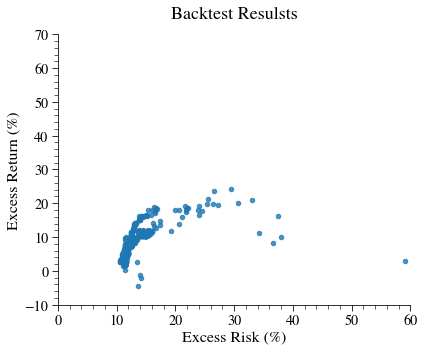

In [8]:
# risk-return plot 
results_df[['excess_return', 'excess_risk']]\
    .rename(
        columns={
            'excess_return':'Excess Return (%)', 
            'excess_risk':'Excess Risk (%)'
        })\
    .plot(
        kind='scatter', 
        x='Excess Risk (%)', 
        y='Excess Return (%)', 
        title='Backtest Resulsts', 
        alpha=0.8,
        figsize=(6,5),
        c='C0')

# x and y axis limits
plt.xlim(left=0.0, right=60.0)
plt.ylim(bottom=-10.0, top=70.0)

In [9]:
print(f'done backtesting for {MODEL_BASE_NAME}.')

done backtesting for RL_CNN.


In [10]:
agent.policy